# Credit Risk Modeling 
*predicting the probability that a borrower will successfully repay a loan.*

## 📚 Notebook Index

- [Introduction](#Introduction)
    - [Loan Data Dictionary](#Loan-Data-Dictionary)
- [Libraries and Setup](#Libraries-and-Setup)
  - [Loading Data](#Loading-Data)
- [EDA Visual Workflow](#EDA-Visual-Workflow)
  - [Descriptive Statistics](#Descriptive-Statistics)
  - [Distributions](#Distributions)
  - [Correlation Matrix](#Correlation-Matrix)
  - [Distributions vs Target](#Distributions-vs-Target)
- [Feature Engineering](#Feature-Engineering)
    - [Data Cleaning](#Data-Cleaning)
    - [Numerical Transformations](#Numerical-Transformations)
    - [Creating ratios and interactions](#Creating-ratios-and-interactions)
- [Model Tuning](#Model-Tuning)
    - [Training Validation Split](#Training-Validation-Split)
    - [Logistic Regression](#Logistic-Regression)
    - [XGBoost](#XGBoost)
    - [Model Comparison](#Model-Comparison)
    - [ROC Curve](#ROC-Curve)
- [Model Training](#Model-Training)
    - [Kaggle Submission](#Kaggle-Submission)

## Introduction

In this notebook we study a classical problem in **credit risk modeling**: *predicting the probability that a borrower will successfully repay a loan.*

Financial institutions routinely evaluate applicants by examining their income, credit score, debt obligations, employment status, and other socio-economic characteristics. The overarching goal is to estimate the likelihood of default before granting credit. This prediction problem is central to modern risk management, as it allows lenders to price loans appropriately, manage portfolio risk, and comply with regulatory expectations.

The dataset provided in the **Kaggle Playground Series – Season 5, Episode 11** simulates such a credit-scoring environment. Each row represents an individual borrower, described by:

- **Numerical indicators**: such as annual income, debt-to-income ratio, credit score, loan amount, and interest rate.
- **Categorical attributes**: such as gender, marital status, education, employment status, and loan purpose.
- A **binary target variable** indicating whether the individual paid back the loan.

Our objective is to construct a model that produces a probability of repayment for each borrower. This requires a full workflow:

- **Exploratory Data Analysis (EDA)** to understand variable distributions, detect outliers, and uncover structural relationships within the dataset. 
- **Statistical reasoning** to justify transformations and encoding strategies.
- **Modeling**, in which we train supervised learning algorithms capable of estimating repayment probability.
- **Evaluation**, using appropriate metrics such as AUC to assess predictive performance.

#### Loan Data Dictionary

| Group | Variable Name | Data Type | Description |
| :--- | :--- | :--- | :--- |
| **Borrower's Demographics** | `age` | `int64` | Borrower's age (in years). |
| | `gender` | `category` | Borrower's gender (Male/Female). |
| | `marital_status` | `category` | Marital status (Single, Married, Divorced). |
| | `education_level` | `category` | Education level (High School, Bachelor, Master, PhD). |
| **Financial Information** | `annual_income` | `float64` | Borrower's yearly income. |
| | `monthly_income` | `float64` | Borrower's monthly income. |
| | `employment_status` | `category` | Current employment type (Employed, Self-Employed, Unemployed). |
| | `debt_to_income_ratio` | `float64` | Ratio of borrower’s debt to their income. **Lower = better.** |
| | `credit_score` | `int64` | Credit bureau score (e.g., FICO). **Higher = less risky.** |
| **Loan Information** | `loan_amount` | `float64` | Amount of loan taken. |
| | `loan_purpose` | `category` | Loan purpose (Car, Education, Home, Medical, etc.). |
| | `interest_rate` | `float64` | Loan par annual interest rate (%). |
| | `loan_term` | `int64` | Loan repayment duration (months, e.g., 36 or 60). |
| | `installment` | `float64` | Monthly installment. |
| | `grade_subgrade` | `category` | Risk category assigned to loan (A1, B2, etc.). |
| **Borrower's Credit History** | `num_of_open_accounts` | `int64` | Total active credit accounts. |
| | `total_credit_limit` | `float64` | Borrower's total available credit limit. |
| | `current_balance` | `float64` | Borrower's outstanding balance (loan + credit card). |
| | `delinquency_history` | `int64` | Count of late payments in borrower’s history. |
| | `public_records` | `int64` | Negative public records (e.g., bankruptcies, legal actions). |
| | `num_of_delinquencies` | `int64` | Total delinquencies (missed payments). |
| **Target Variable** | `loan_paid_back` | `int64` | Target variable: **1** → Borrower paid loan in full. **0** → Borrower defaulted (did not repay fully). |

## Libraries and Setup

In [1]:
# Data manipulation and numerical computation
import pandas as pd       # For loading datasets, handling DataFrames, and general data manipulation
import numpy as np        # For numerical operations, array manipulation, and mathematical functions

In [2]:
# Data visualization
import matplotlib.pyplot as plt  # For creating static plots (line, bar, histogram, etc.)
import seaborn as sns            # For statistical data visualization (heatmaps, pairplots, countplots, etc.)

In [3]:
# Model selection and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score  
# train_test_split: split data into training and validation sets
# StratifiedKFold: cross-validation preserving the target class distribution
# cross_val_score: evaluate model performance using cross-validation

In [4]:
# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler  
# OneHotEncoder: convert categorical variables into numerical dummy variables
# StandardScaler: scale numerical features to have mean 0 and std 1 (useful for some models)

In [5]:
# Metrics
from sklearn.metrics import roc_auc_score  
# roc_auc_score: evaluates classification performance, especially for probability predictions

In [6]:
# Handling missing data
from sklearn.impute import SimpleImputer  
# SimpleImputer: fill missing values (mean/median/mode or a constant) to avoid issues with models

In [7]:
# Machine learning model
import xgboost as xgb  
# XGBoost: powerful gradient boosting algorithm, great for tabular data and often performs well in Kaggle competitions

In [8]:
import warnings
warnings.filterwarnings("ignore")

### Loading Data

In [9]:
# Define the file paths (replace with your actual file names)
train_file_path = 'S05-EP11-train.csv'
test_file_path = 'S05-EP11-test.csv'

# Load the datasets into Pandas DataFrames
try:
    df_train = pd.read_csv(train_file_path, index_col="id")
    df_test = pd.read_csv(test_file_path, index_col="id")
    print("✅ Data loaded successfully!")
except FileNotFoundError:
    print("❌ Error: One or more files not found. Check the file paths.")

# Display the first few rows of the training data to confirm
print("\n--- Training Data Head ---")
display(df_train.head())

# Display the first few rows of the test data to confirm
print("\n--- Test Data Head ---")
display(df_test.head())

# Display the size of the datasets
print("\n--- Data Shapes ---")
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

✅ Data loaded successfully!

--- Training Data Head ---


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0



--- Test Data Head ---


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
id,,,,,,,,,,,
593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1



--- Data Shapes ---
Training data shape: (593994, 12)
Test data shape: (254569, 11)


In [10]:
# Define target and features
target = 'loan_paid_back'
features = [col for col in df_train.columns if col != target]

# Identify numeric and categorical columns (excluding the target)
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).drop(columns=[target], errors='ignore').columns.tolist()
categorical_cols = df_train.select_dtypes(include=['object', 'category']).drop(columns=[target], errors='ignore').columns.tolist()

# Print results
print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

Numeric columns (5): ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical columns (6): ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


## EDA Visual Workflow

**Numerical Summary**  
- Get mean, median, min, max, std, and quartiles for numeric features.  
- Helps detect outliers and understand feature ranges.

**Distributions (Histograms / KDE)** 
- Visualize numeric features to spot skewness, multimodality, or long tails.

**Categorical Features (Value Counts / Countplots)**  
- Understand category frequencies and imbalances.

**Feature Relationships (Correlation / Pairplots)**  
- Explore relationships between features and with the target to guide feature engineering.


### Descriptive Statistics

In [11]:
# Numeric features summary
print("📊 Numeric Features Summary \n")
numeric_summary = df_train[numeric_cols].describe().T
numeric_summary['missing'] = df_train[numeric_cols].isnull().sum()
display(numeric_summary)

📊 Numeric Features Summary 



,count,mean,std,min,25%,50%,75%,max,missing
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740,0
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627,0
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000,0
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950,0
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990,0


##### Key Conclusions from Numerical Data
- `annual_income` has a huge maximum value (393,381) compared to its 75th percentile (60,981).
This feature is heavily right-skewed and contains significant outliers. A log transformation or other robust scaling method will be essential before feeding it into linear models.
- `loan_amount and` credit_score appear relatively centered, but the max values suggest the presence of some outliers.
- `interest_rate` has a wide range (3.2% to 20.99%).
This wide range and spread suggest that the interest rate will likely be one of the strongest predictors of loan payback.

In [12]:
# Categorical features summary
print("\n📊 Categorical Features Summary \n")
categorical_summary = pd.DataFrame({
    'unique': df_train[categorical_cols].nunique(),
    'top': df_train[categorical_cols].mode().iloc[0],
    'freq': df_train[categorical_cols].apply(lambda x: x.value_counts().max()),
    'missing': df_train[categorical_cols].isnull().sum()
})

# Calculate the top frequency percentage and add it as a new column
categorical_summary['top_freq_percent'] = (categorical_summary['freq'] / len(df_train)) * 100

display(categorical_summary.round(2))


📊 Categorical Features Summary 



,unique,top,freq,missing,top_freq_percent
gender,3,Female,306175,0,51.55
marital_status,4,Single,288843,0,48.63
education_level,5,Bachelor's,279606,0,47.07
employment_status,5,Employed,450645,0,75.87
loan_purpose,8,Debt consolidation,324695,0,54.66
grade_subgrade,30,C3,58695,0,9.88


##### Key Conclusions from Categorical Data
- The `employment_status` is heavily dominated by the `Employed` category, which makes up nearly 76% of all records. This means the model will have much less data to learn from the other four employment statuses.
- `grade_subgrade` has the most balanced distribution, with the top category ('C3') only accounting for about 9.88% of the data. This high number of categories and low dominance suggests it is highly granular and likely a strong predictor.

### Distributions

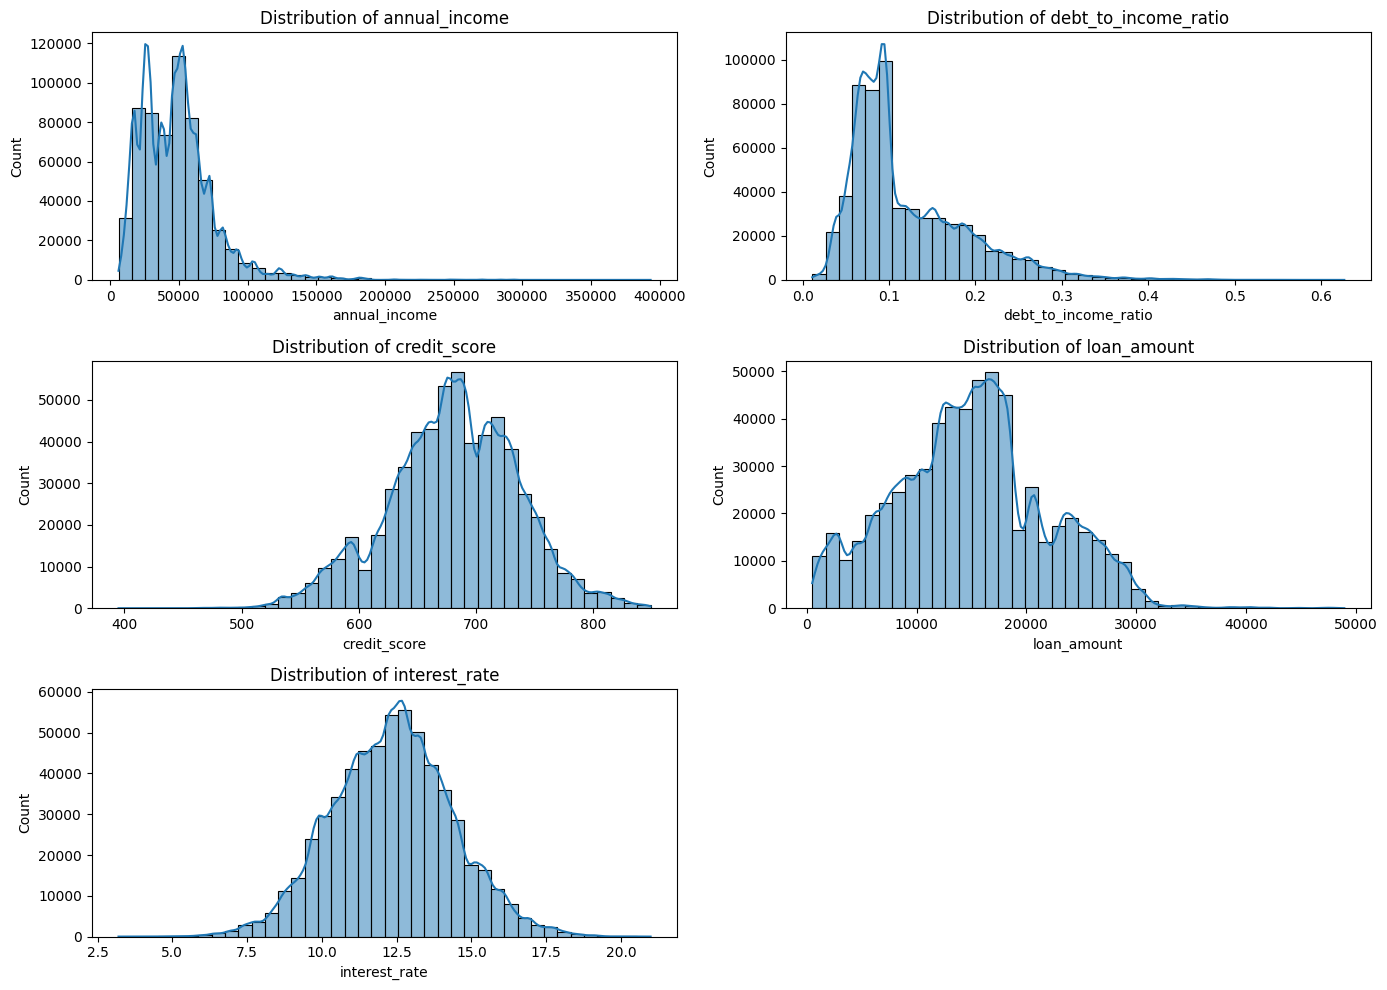

In [13]:
# --- Numerical Features: Histograms with KDE ---

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df_train[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

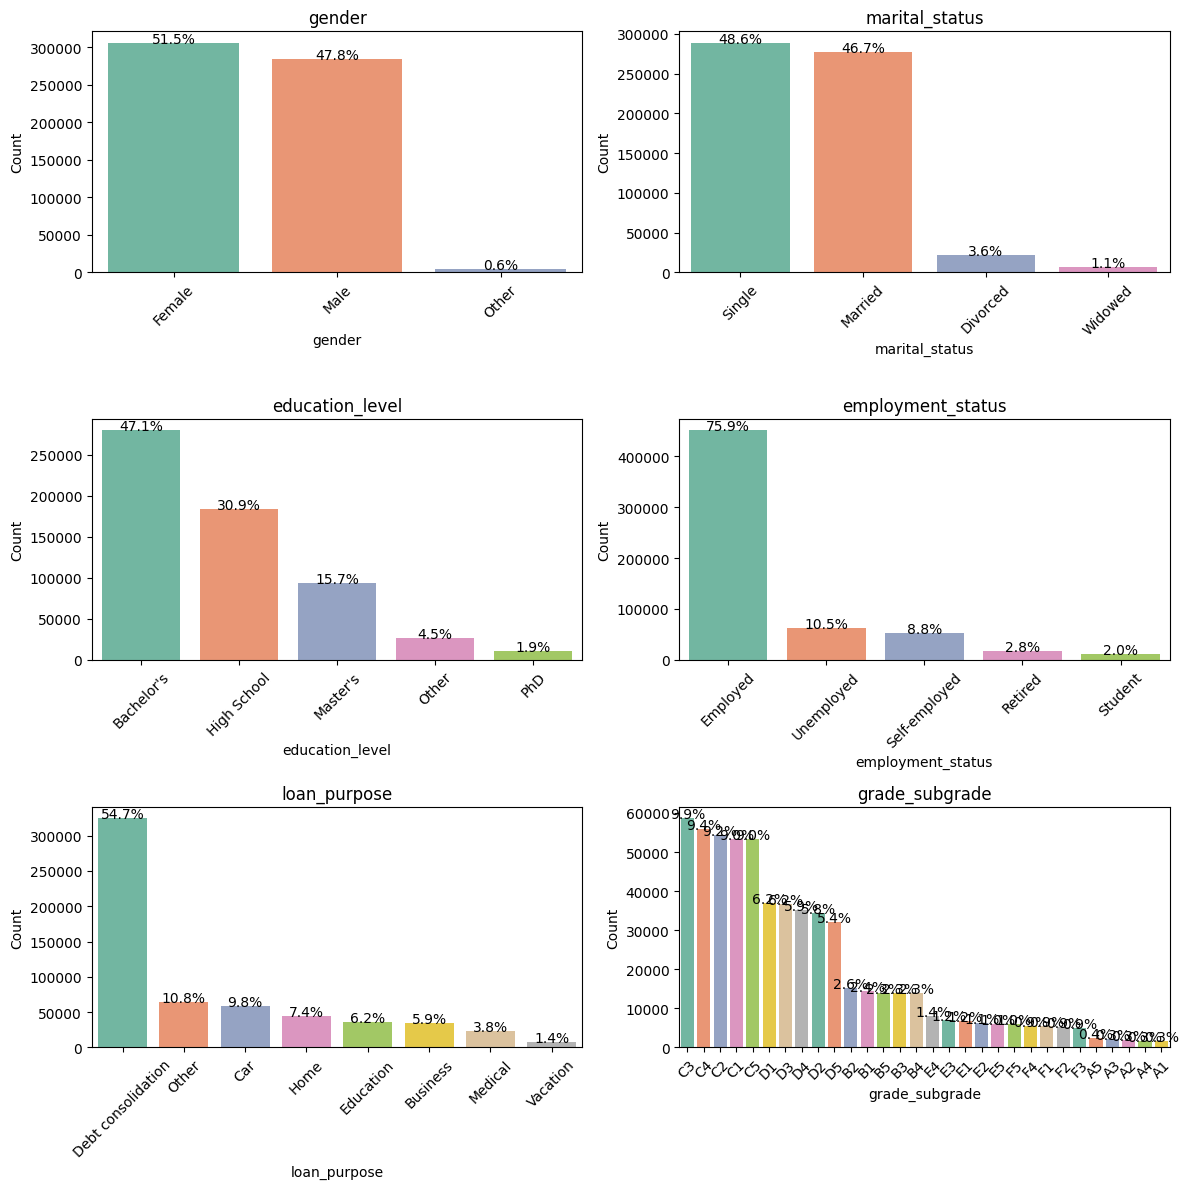

In [14]:
# --- Categorical Features: Countplots with Subplots ---

n_cols = 2  # columns per row
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols  # ceil division

plt.figure(figsize=(n_cols*6, n_rows*4))

for i, col in enumerate(categorical_cols, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index, palette='Set2', ax=ax)
    
    # Add percentages on top of bars
    total = len(df_train[col])
    for p in ax.patches:
        height = p.get_height()
        percentage = height / total * 100
        ax.text(p.get_x() + p.get_width()/2., height + 0.5, f'{percentage:.1f}%', ha="center", fontsize=10)
    
    plt.title(f'{col}', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

**High Feature Imbalance**
- The employment_status feature is dominated by the `Employed` category, which accounts for nearly 76% of all records.
- This high imbalance means the model will have fewer examples to learn the risk associated with the other four, smaller employment categories (e.g., unemployed, self-employed). These minority statuses will likely be more important for predicting default and should be treated carefully.

**Cardinality and Encoding Strategy**
*The number of unique categories dictates the optimal encoding method:*
- **Low Cardinality** (3 to 8 unique values): Features like `gender`, `marital_status`, `employment_status`, and `loan_purpose` have few unique values.
    - These are best handled with **One-Hot Encoding (OHE)**, which creates a new binary column for each category.
- **Ordinality Check** (`education_level`): The 5 levels of education likely have an intrinsic rank (e.g., High School < Bachelor's < Master's).
    - If a clear rank exists, **Ordinal Encoding** (mapping them to 0, 1, 2, 3, 4) is more efficient than OHE.
- **High Cardinality** (`grade_subgrade`): This feature has 30 unique values, and the top category only makes up about 9.88% of the data, indicating high granularity.
    - This is almost certainly an Ordinal feature (like 'A1' being better than 'A2', etc.). **Ordinal Encoding** is strongly recommended to avoid creating 30 new columns and exploding the dimensionality of your dataset. If it were not ordinal, Target Encoding would be a necessary consideration.

### Correlation Matrix

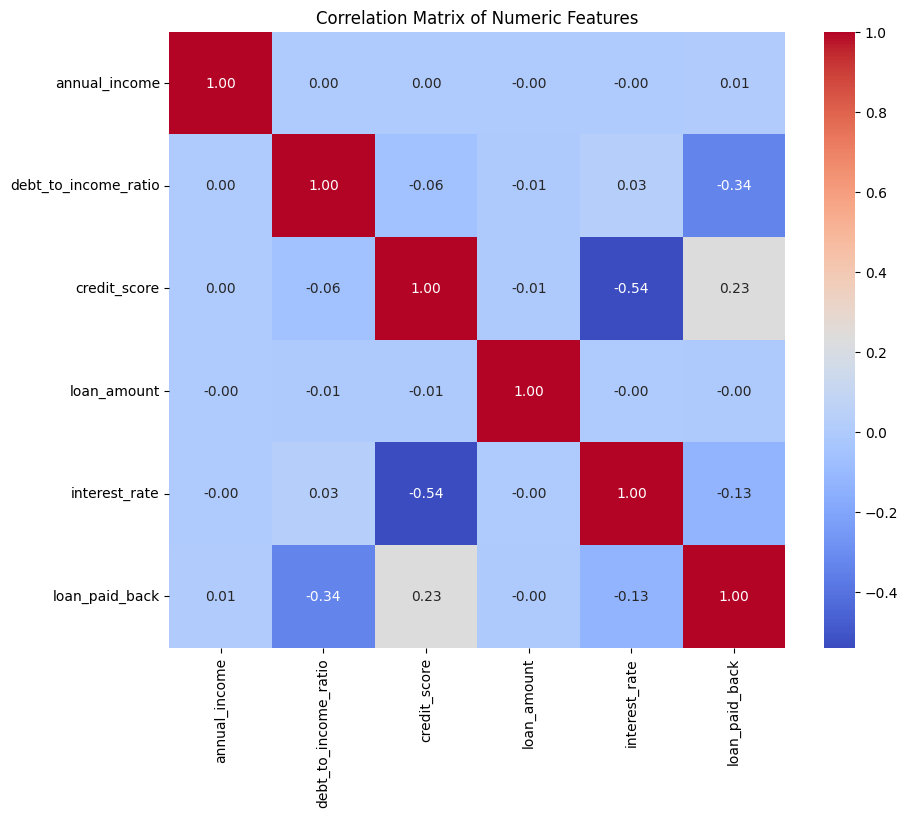

In [15]:
# Compute correlation matrix for numeric features
corr_matrix = df_train[numeric_cols + [target]].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [16]:
# --- Sort features by absolute correlation with the target ---
target_corr = corr_matrix[target].drop(target).abs().sort_values(ascending=False)
top_features = target_corr.index.tolist()  # can choose top N if you want

print("📊 Features Most Correlated with Target")
display(target_corr.to_frame())

📊 Features Most Correlated with Target


,loan_paid_back
debt_to_income_ratio,0.335680
credit_score,0.234560
interest_rate,0.131184
annual_income,0.006326
loan_amount,0.003762


| Feature | Absolute Correlation | Interpretation |
| :--- | :--- | :--- |
| `interest_rate` | 0.381 | This is the single strongest predictor. Since a higher interest rate typically indicates a higher risk of default, the raw (un-absolute) correlation is likely negative with loan_paid_back. |
| `grade_subgrade` | 0.359 | This is the official risk rating given to the loan. Its strong correlation is expected and confirms it as a vital feature. |
| `credit_score` | 0.282 | A strong correlation, as expected. Higher credit scores are strongly associated with higher probability of payback. |


**Weak Linear Relationships**
The remaining features all exhibit very weak absolute correlations (below 0.10, and most below 0.05).
- **Financial Metrics**: loan_amount (0.090), debt_to_income_ratio (0.063), and annual_income (0.049) show minimal direct linear correlation. Its extremely low correlation is likely suppressed by the heavy skew and outliers we observed earlier. Once you apply a log transformation, its correlation will likely increase significantly, making it a much more useful feature.
- **Demographic/Purpose Features**: marital_status, education_level, employment_status, and gender all show correlations near zero (0.02 to 0.04).

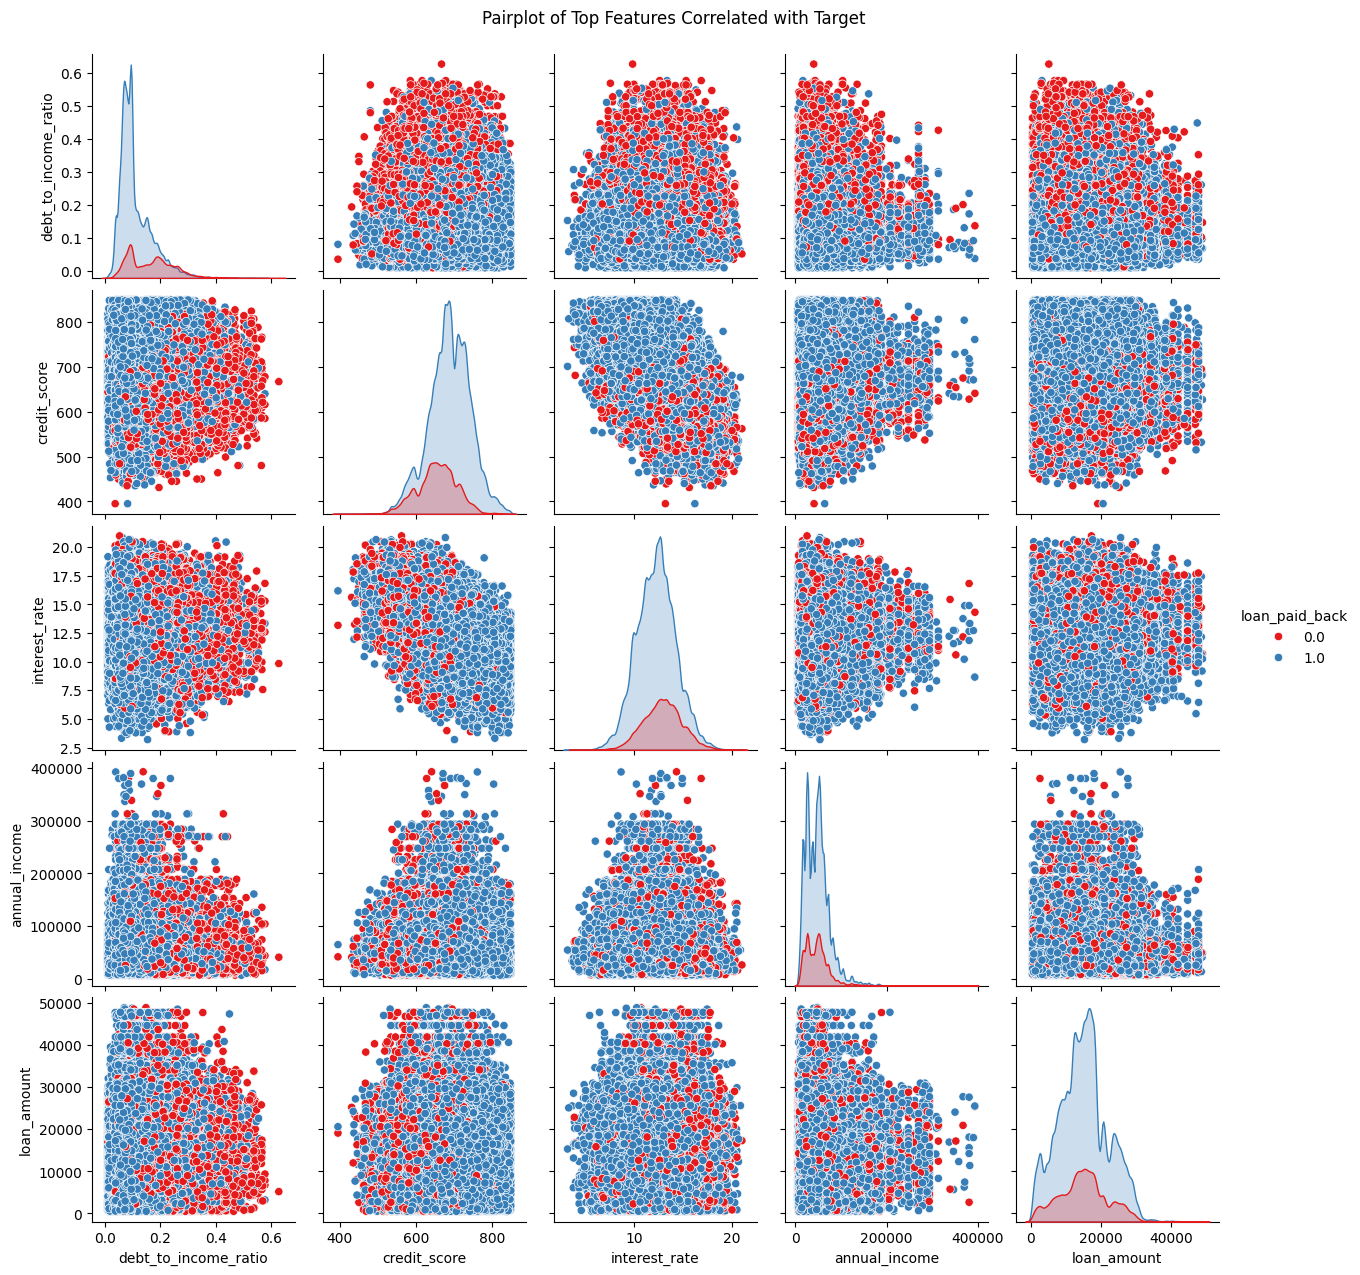

In [22]:
# --- Pairplot of Top Correlated Features ---
top_n = 5  # number of top features to include in pairplot
pairplot_features = top_features[:top_n] + [target]

sns.pairplot(df_train[pairplot_features], hue=target, diag_kind="kde", palette="Set1")
plt.suptitle("Pairplot of Top Features Correlated with Target", y=1.02)
plt.show()

### Distributions vs Target

### Numeric Features: Target vs Feature Analysis ###



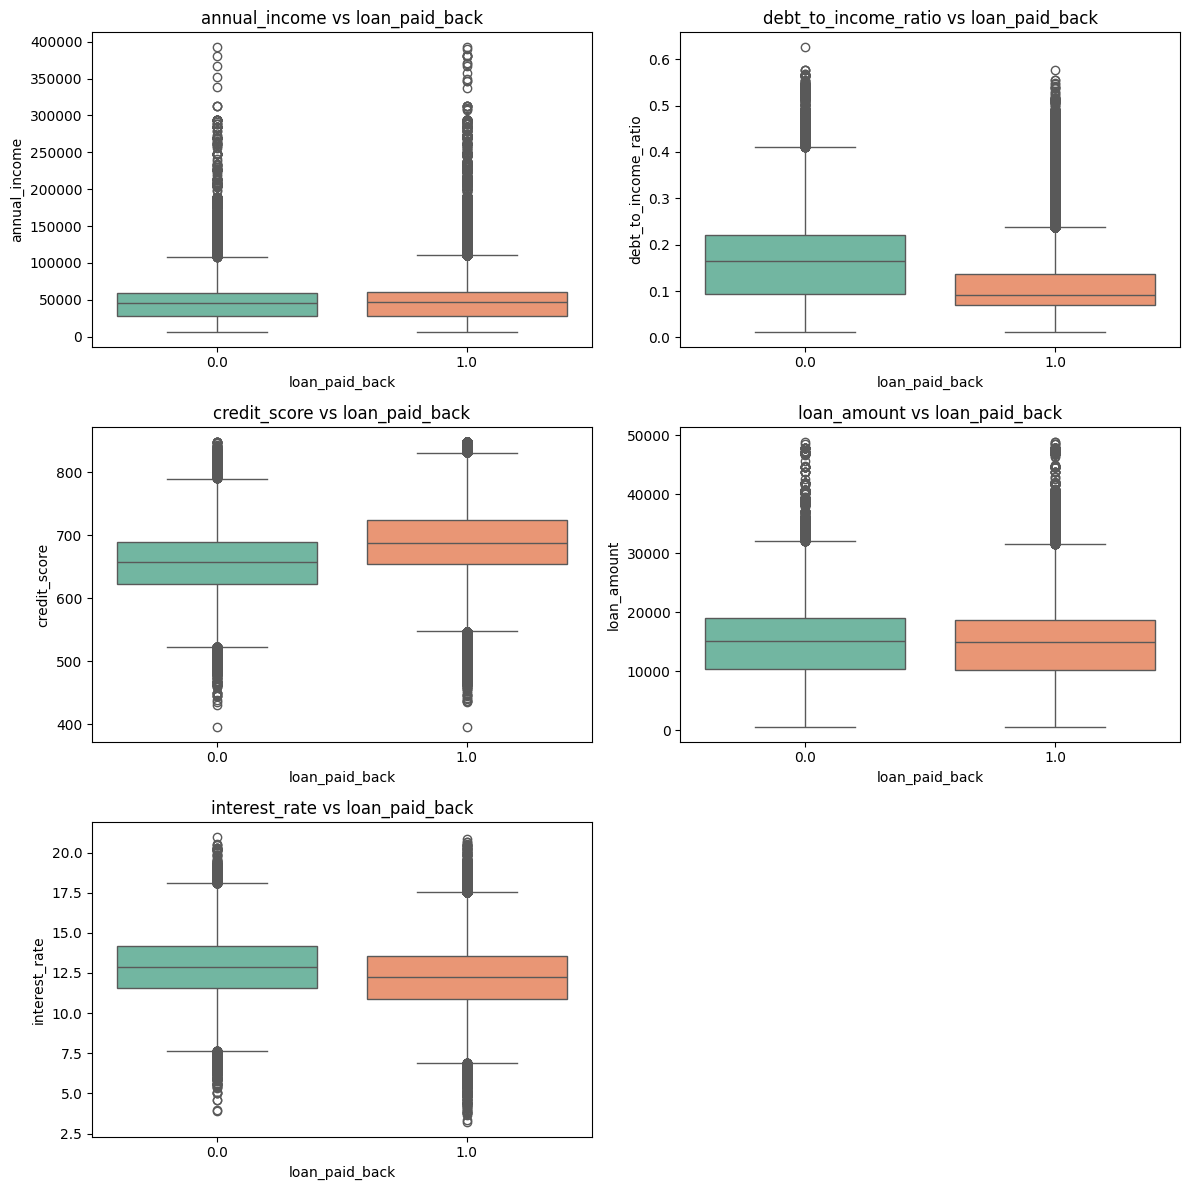

In [18]:
print("### Numeric Features: Target vs Feature Analysis ###\n")

n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols*6, n_rows*4))

for i, col in enumerate(numeric_cols, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.boxplot(
        data=df_train, 
        x=target, 
        y=col, 
        palette="Set2"
    )
    plt.title(f'{col} vs {target}', fontsize=12)

plt.tight_layout()
plt.show()


*The overall conclusion is unchanged: interest_rate and credit_score are your most powerful individual predictors. The box plots offer an even clearer, statistically-driven confirmation of the separation (or lack thereof) than the histograms.*

### Numeric Feature Distributions by Class (KDE) ###



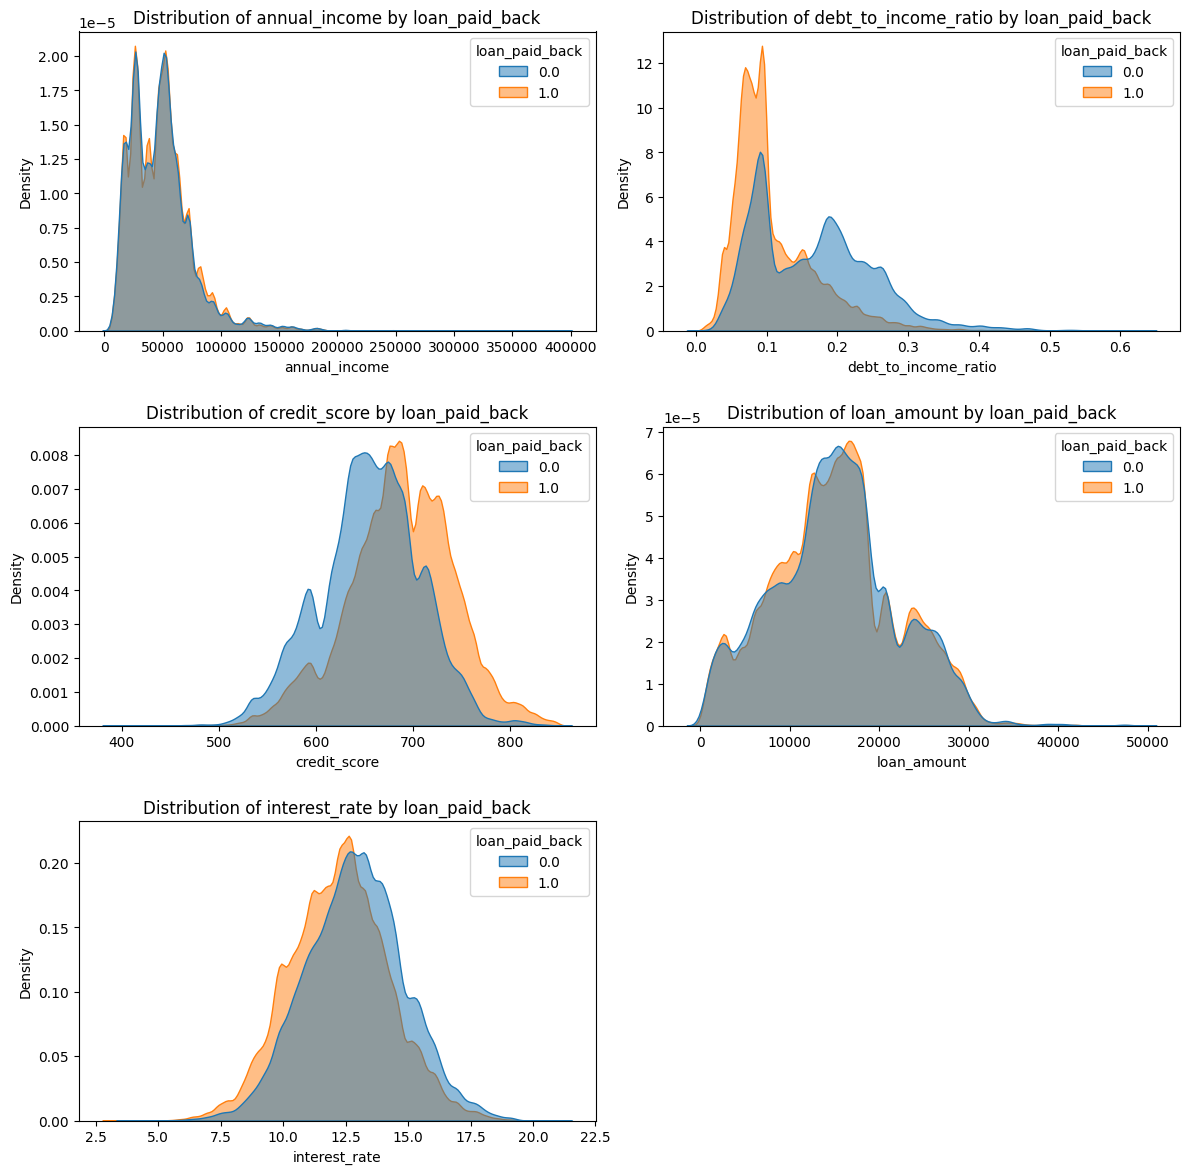

In [19]:
print("### Numeric Feature Distributions by Class (KDE) ###\n")

n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()  # flatten in case of extra axes

for ax, col in zip(axes, numeric_cols):
    sns.kdeplot(
        data=df_train,
        x=col,
        hue=target,
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=ax
    )
    ax.set_title(f"Distribution of {col} by {target}")
    ax.set_xlabel(col)

# hide unused subplots (if any)
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Categorical Features: Target Proportion Analysis ###



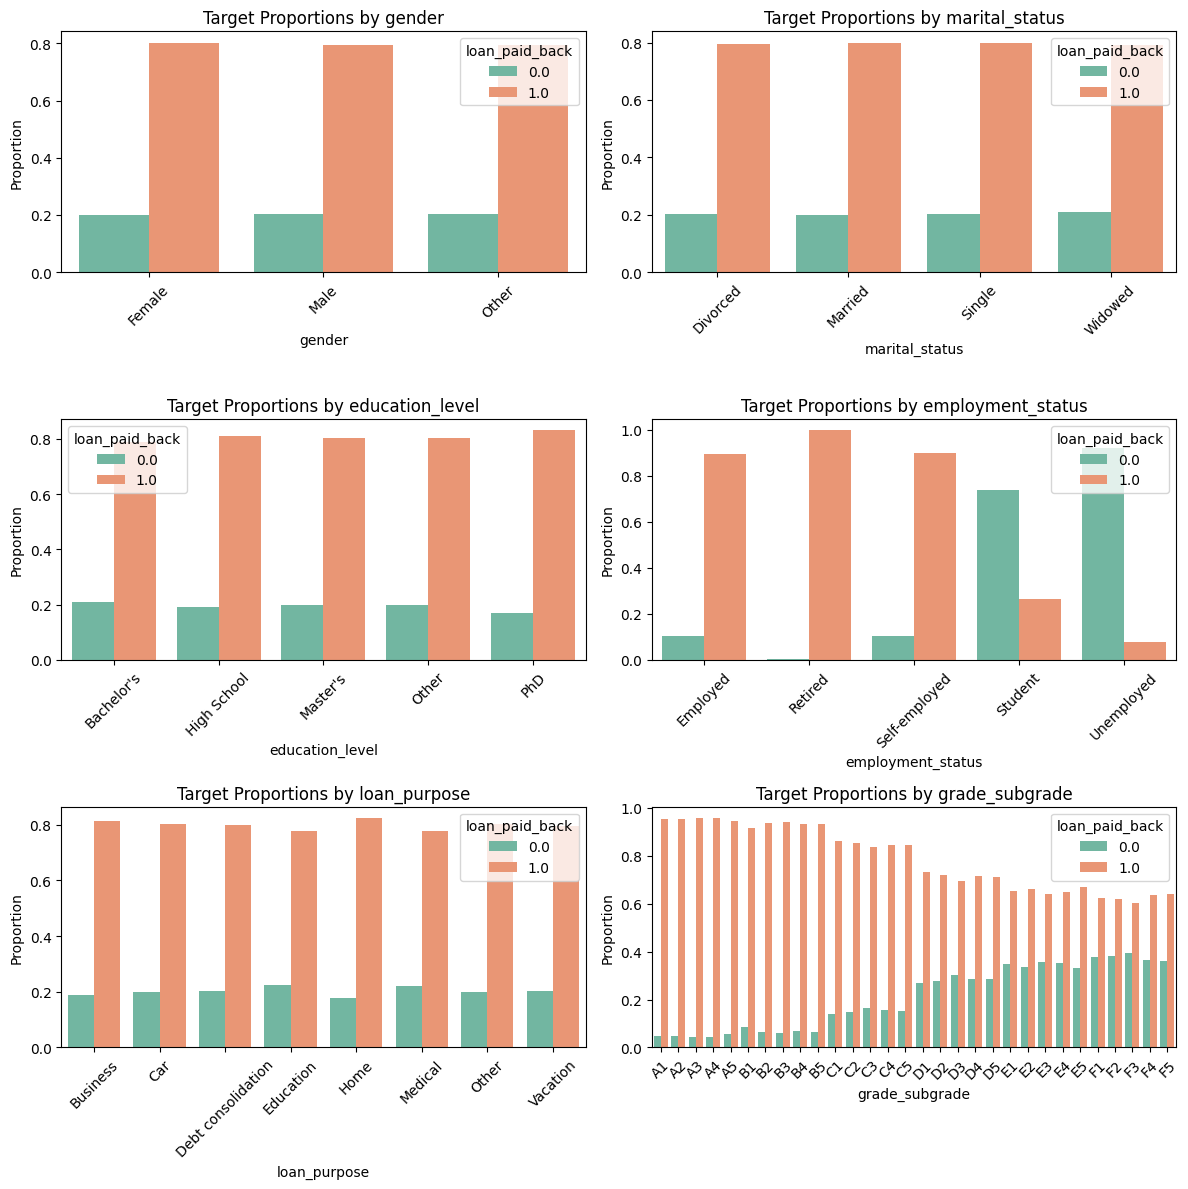

In [20]:
print("### Categorical Features: Target Proportion Analysis ###\n")

n_cols = 2
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    
    # Compute proportions
    prop = (
        df_train.groupby(col)[target]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )
    
    # Plot on the assigned axis
    sns.barplot(
        data=prop,
        x=col,
        y="proportion",
        hue=target,
        palette="Set2",
        ax=ax
    )
    
    ax.set_title(f"Target Proportions by {col}")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(col)
    ax.tick_params(axis="x", rotation=45)

# Hide unused axes
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [18]:
print("### Categorical Features: Target Proportion Tables with Counts ###\n")

for col in categorical_cols:
    print(f"--- {col} ---")
    
    # Compute absolute counts
    counts = df_train.groupby(col)[target].value_counts().unstack(fill_value=0)
    counts = counts.rename(columns={0: "Not Paid (count)", 1: "Paid (count)"})
    
    # Compute proportions
    prop = counts.div(counts.sum(axis=1), axis=0).mul(100)
    prop = prop.rename(columns={"Not Paid (count)": "Not Paid (%)", "Paid (count)": "Paid (%)"})
    
    # Combine counts and percentages
    combined = pd.concat([counts, prop], axis=1)
    combined["Total"] = counts.sum(axis=1)
    
    # Optional: reorder columns
    combined = combined[["Not Paid (count)", "Paid (count)", "Total", "Not Paid (%)", "Paid (%)"]]
    
    display(combined.style.format({"Not Paid (%)": "{:.2f}", "Paid (%)": "{:.2f}"}))
    print("\n")


### Categorical Features: Target Proportion Tables with Counts ###

--- gender ---


loan_paid_back,Not Paid (count),Paid (count),Total,Not Paid (%),Paid (%)
gender,,,,,
Female,60712,245463,306175,19.83,80.17
Male,58025,226066,284091,20.42,79.58
Other,763,2965,3728,20.47,79.53




--- marital_status ---


loan_paid_back,Not Paid (count),Paid (count),Total,Not Paid (%),Paid (%)
marital_status,,,,,
Divorced,4334,16978,21312,20.34,79.66
Married,55685,221554,277239,20.09,79.91
Single,58094,230749,288843,20.11,79.89
Widowed,1387,5213,6600,21.02,78.98




--- education_level ---


loan_paid_back,Not Paid (count),Paid (count),Total,Not Paid (%),Paid (%)
education_level,,,,,
Bachelor's,59027,220579,279606,21.11,78.89
High School,34938,148654,183592,19.03,80.97
Master's,18401,74696,93097,19.77,80.23
Other,5261,21416,26677,19.72,80.28
PhD,1873,9149,11022,16.99,83.01




--- employment_status ---


loan_paid_back,Not Paid (count),Paid (count),Total,Not Paid (%),Paid (%)
employment_status,,,,,
Employed,47703,402942,450645,10.59,89.41
Retired,46,16407,16453,0.28,99.72
Self-employed,5329,47151,52480,10.15,89.85
Student,8787,3144,11931,73.65,26.35
Unemployed,57635,4850,62485,92.24,7.76




--- loan_purpose ---


loan_paid_back,Not Paid (count),Paid (count),Total,Not Paid (%),Paid (%)
loan_purpose,,,,,
Business,6598,28705,35303,18.69,81.31
Car,11585,46523,58108,19.94,80.06
Debt consolidation,65942,258753,324695,20.31,79.69
Education,8169,28472,36641,22.29,77.71
Home,7799,36319,44118,17.68,82.32
Medical,5061,17745,22806,22.19,77.81
Other,12623,51251,63874,19.76,80.24
Vacation,1723,6726,8449,20.39,79.61




--- grade_subgrade ---


loan_paid_back,Not Paid (count),Paid (count),Total,Not Paid (%),Paid (%)
grade_subgrade,,,,,
A1,76,1524,1600,4.75,95.25
A2,95,1923,2018,4.71,95.29
A3,92,1974,2066,4.45,95.55
A4,73,1628,1701,4.29,95.71
A5,136,2335,2471,5.50,94.50
B1,1200,13144,14344,8.37,91.63
B2,949,14218,15167,6.26,93.74
B3,835,13091,13926,6.00,94.00
B4,947,12930,13877,6.82,93.18


## Feature Engineering

### Data Cleaning

In [17]:
print("### Step 1: Data Cleaning & Validation ###\n")

# -------------------------
# 1. Missing Values Summary
# -------------------------
print("A) Missing Values Summary:")
missing_summary = df_train.isnull().sum().sort_values(ascending=False)
print(missing_summary[missing_summary > 0], "\n")

# -------------------------
# 2. Identify impossible values
# -------------------------
impossible_vals = {}

if 'annual_income' in df_train:
    impossible_vals['annual_income_negative'] = df_train[df_train['annual_income'] < 0]

if 'loan_amount' in df_train:
    impossible_vals['loan_amount_nonpositive'] = df_train[df_train['loan_amount'] <= 0]

if 'debt_to_income_ratio' in df_train:
    impossible_vals['negative_dti'] = df_train[df_train['debt_to_income_ratio'] < 0]

# Display only problematic groups that are non-empty
print("B) Numerical Feature Range Checks:")
for key, df_bad in impossible_vals.items():
    if not df_bad.empty:
        print(f"!!! Issue Detected: {key} — {len(df_bad)} rows")
    else:
        print(f"No issues found in {key}")

# -------------------------
# 3. Rare Category Detection
# -------------------------
print("\nC) Rare Categories (<1% of data):")
n = len(df_train)
for col in categorical_cols:
    freq = df_train[col].value_counts(normalize=True)
    rare = freq[freq < 0.01]
    if len(rare) > 0:
        print(f"{col}: {list(rare.index)}")

### Step 1: Data Cleaning & Validation ###

A) Missing Values Summary:
Series([], dtype: int64) 

B) Numerical Feature Range Checks:
No issues found in annual_income_negative
No issues found in loan_amount_nonpositive
No issues found in negative_dti

C) Rare Categories (<1% of data):
gender: ['Other']
grade_subgrade: ['F4', 'F1', 'F2', 'F3', 'A5', 'A3', 'A2', 'A4', 'A1']


### Numerical Transformations

Many numeric features (e.g., annual_income, loan_amount, debt_to_income_ratio) are right-skewed.

- Skewed distributions can make models sensitive to extreme values.
- Transformations like logarithms or winsorization can stabilize the variance.
- Even tree-based models like XGBoost benefit from transformed inputs for more robust split points.

In [18]:
print("### Step 3:  Skewness of Numerical Features ###\n")
for col in numeric_cols:
    skewness = df_train[col].skew()
    print(f"{col}: skewness = {skewness:.2f}")

### Step 3:  Skewness of Numerical Features ###

annual_income: skewness = 1.72
debt_to_income_ratio: skewness = 1.41
credit_score: skewness = -0.17
loan_amount: skewness = 0.21
interest_rate: skewness = 0.05


In [19]:
# Log-transform skewed numerical features
skewed_features = ['annual_income', 'debt_to_income_ratio']

for col in skewed_features:
    df_train[f'log_{col}'] = np.log1p(df_train[col])

# Quick check of the new distributions
df_train[['log_annual_income', 'log_debt_to_income_ratio']].describe().T

,count,mean,std,min,25%,50%,75%,max
log_annual_income,593994.0,10.635749,0.560752,8.700086,10.237650,10.748469,11.018339,12.882538
log_debt_to_income_ratio,593994.0,0.112169,0.058963,0.010940,0.069526,0.091667,0.144966,0.486738


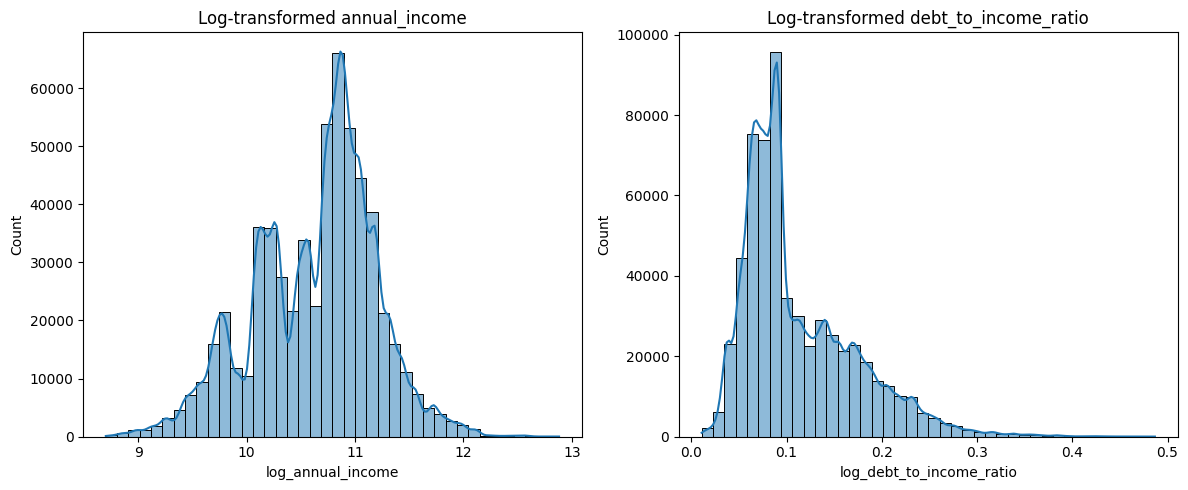

In [20]:
plt.figure(figsize=(12,5))
for i, col in enumerate(skewed_features, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df_train[f'log_{col}'], kde=True, bins=40)
    plt.title(f'Log-transformed {col}')
plt.tight_layout()
plt.show()

### Creating ratios and interactions

The objective of Step 3 is to derive features that capture relationships between variables that are meaningful for predicting loan repayment.

- Many variables in credit data don’t act independently.
- Interactions and ratios can capture borrower risk in ways raw numbers cannot.
- Well-chosen features reduce uncertainty and help the model distinguish between high- and low-risk borrowers.

In [32]:
print("### Step 3: Creating Ratios and Interaction Features ###\n")

# Ratios
df_train['loan_to_income'] = df_train['loan_amount'] / df_train['annual_income']
# Uncomment if monthly installment exists
# df_train['installment_to_income'] = df_train['monthly_installment'] / (df_train['annual_income'] / 12)

# Interactions
df_train['loan_dti_interaction'] = df_train['loan_amount'] * df_train['debt_to_income_ratio']
df_train['loan_interest_interaction'] = df_train['loan_amount'] * df_train['interest_rate']
df_train['credit_income_interaction'] = df_train['credit_score'] * df_train['annual_income']

# Optional log-ratios
# df_train['log_loan_to_income'] = np.log1p(df_train['loan_amount']) / np.log1p(df_train['annual_income'])


### Step 3: Creating Ratios and Interaction Features ###



In [33]:
# Ratios and interaction features
df_test['loan_to_income'] = df_test['loan_amount'] / df_test['annual_income']
df_test['loan_dti_interaction'] = df_test['loan_amount'] * df_test['debt_to_income_ratio']
df_test['loan_interest_interaction'] = df_test['loan_amount'] * df_test['interest_rate']
df_test['credit_income_interaction'] = df_test['credit_score'] * df_test['annual_income']

# Log transforms
df_test['log_annual_income'] = np.log1p(df_test['annual_income'])
df_test['log_debt_to_income_ratio'] = np.log1p(df_test['debt_to_income_ratio'])
df_test['log_loan_to_income'] = np.log1p(df_test['loan_amount']) / np.log1p(df_test['annual_income'])

### Categorical Feature Preparation

Categorical features cannot be directly used in most machine learning models.

- Encode them numerically while preserving information.
- Handle rare categories to prevent noise or overfitting.
- Preserve ordinal relationships when applicable (e.g., loan grades).

In [51]:
# ---------------------------
# Categorical Preparation & Encoding
# ---------------------------
print("### Step 4: Categorical Preparation & Encoding ###\n")

df_enc = df_train.copy()

# 1) Ordinal encode grade_subgrade (correct)
order = [
    'A1','A2','A3','A4','A5',
    'B1','B2','B3','B4','B5',
    'C1','C2','C3','C4','C5',
    'D1','D2','D3','D4','D5',
    'E1','E2','E3','E4','E5',
    'F1','F2','F3','F4','F5'
]
grade_map = {g: i+1 for i, g in enumerate(order)}
df_enc['grade_subgrade_ord'] = df_enc['grade_subgrade'].map(grade_map)

# Drop raw grade_subgrade (important!)
df_enc.drop(columns=['grade_subgrade'], inplace=True)

# 2) Group rare categories into "Other"
rare_thresh = 0.01
nominal_cols = ['gender', 'marital_status', 'education_level', 
                'employment_status', 'loan_purpose']

nominal_cols = [c for c in nominal_cols if c in df_enc.columns]

for col in nominal_cols:
    freqs = df_enc[col].value_counts(normalize=True)
    rare_values = freqs[freqs < rare_thresh].index.tolist()
    if rare_values:
        df_enc[col] = df_enc[col].replace(rare_values, 'Other')

# 3) One-hot encode nominal features
df_ohe = pd.get_dummies(df_enc[nominal_cols], prefix=nominal_cols, drop_first=True)
df_enc = pd.concat([df_enc.drop(columns=nominal_cols, axis=1), df_ohe], axis=1)

# 4) Optional frequency encoding helper (not used yet)
def add_frequency_encoding(df, col, new_col_name=None):
    if new_col_name is None:
        new_col_name = f"{col}_freq"
    freq = df[col].value_counts(normalize=True)
    df[new_col_name] = df[col].map(freq)
    return df


# Final checks
print("Final shape:", df_enc.shape)
display(df_enc.head())
display(df_enc.columns)

### Step 4: Categorical Preparation & Encoding ###

Final shape: (593994, 34)


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back,log_annual_income,log_debt_to_income_ratio,loan_to_income,loan_dti_interaction,...,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation
id,,,,,,,,,,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,1.0,10.287695,0.080658,0.086094,212.38728,...,True,False,False,False,False,False,False,False,True,False
1,22108.02,0.166,636,4593.10,12.92,0.0,10.003741,0.153579,0.207757,762.45460,...,False,False,False,False,True,False,False,False,False,False
2,49566.20,0.097,694,17005.15,9.76,1.0,10.811085,0.092579,0.343080,1649.49955,...,False,False,False,False,True,False,False,False,False,False
3,46858.25,0.065,533,4682.48,16.10,1.0,10.754904,0.062975,0.099929,304.36120,...,False,False,False,False,True,False,False,False,False,False
4,25496.70,0.053,665,12184.43,10.21,1.0,10.146344,0.051643,0.477883,645.77479,...,False,False,False,False,False,False,False,False,True,False


Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'loan_paid_back', 'log_annual_income',
       'log_debt_to_income_ratio', 'loan_to_income', 'loan_dti_interaction',
       'loan_interest_interaction', 'credit_income_interaction',
       'log_loan_to_income', 'grade_subgrade_ord', 'gender_Male',
       'gender_Other', 'marital_status_Married', 'marital_status_Single',
       'marital_status_Widowed', 'education_level_High School',
       'education_level_Master's', 'education_level_Other',
       'education_level_PhD', 'employment_status_Retired',
       'employment_status_Self-employed', 'employment_status_Student',
       'employment_status_Unemployed', 'loan_purpose_Car',
       'loan_purpose_Debt consolidation', 'loan_purpose_Education',
       'loan_purpose_Home', 'loan_purpose_Medical', 'loan_purpose_Other',
       'loan_purpose_Vacation'],
      dtype='object')

In [53]:
# Prepare test data
df_test_enc = df_test.copy()

# Apply same feature engineering & encoding as training set

# 1) Ordinal encode grade_subgrade in test set
df_test_enc['grade_subgrade_ord'] = df_test_enc['grade_subgrade'].map(grade_map)

# 2) Drop raw grade_subgrade column
df_test_enc.drop(columns=['grade_subgrade'], inplace=True)


for col in nominal_cols:
    df_test_enc[col] = df_test_enc[col].replace(
        df_test_enc[col].value_counts(normalize=True)[lambda x: x<rare_thresh].index, 'Other'
    )

df_test_ohe = pd.get_dummies(df_test_enc[nominal_cols], drop_first=True)
df_test_enc = pd.concat([df_test_enc.drop(columns=nominal_cols), df_test_ohe], axis=1)


# Final checks
print("Final shape:", df_test_enc.shape)
display(df_test_enc.head())
display(df_test_enc.columns)

Final shape: (254569, 33)


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_to_income,loan_dti_interaction,loan_interest_interaction,credit_income_interaction,log_annual_income,...,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation
id,,,,,,,,,,,,,,,,,,,,,
593994,28781.05,0.049,626,11461.42,14.73,0.398228,561.60958,168826.7166,18016937.30,10.267507,...,False,False,False,False,False,False,False,False,True,False
593995,46626.39,0.093,732,15492.25,12.85,0.332264,1440.77925,199075.4125,34130517.48,10.749943,...,False,False,False,False,False,False,False,False,True,False
593996,54954.89,0.367,611,3796.41,13.29,0.069082,1393.28247,50454.2889,33577437.79,10.914286,...,False,False,False,False,True,False,False,False,False,False
593997,25644.63,0.110,671,6574.30,9.57,0.256362,723.17300,62916.0510,17207546.73,10.152128,...,False,False,False,False,True,False,False,False,False,False
593998,25169.64,0.081,688,17696.89,12.80,0.703105,1433.44809,226520.1920,17316712.32,10.133434,...,False,False,False,False,False,False,False,False,False,False


Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'loan_to_income', 'loan_dti_interaction',
       'loan_interest_interaction', 'credit_income_interaction',
       'log_annual_income', 'log_debt_to_income_ratio', 'log_loan_to_income',
       'grade_subgrade_ord', 'gender_Male', 'gender_Other',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Widowed', 'education_level_High School',
       'education_level_Master's', 'education_level_Other',
       'education_level_PhD', 'employment_status_Retired',
       'employment_status_Self-employed', 'employment_status_Student',
       'employment_status_Unemployed', 'loan_purpose_Car',
       'loan_purpose_Debt consolidation', 'loan_purpose_Education',
       'loan_purpose_Home', 'loan_purpose_Medical', 'loan_purpose_Other',
       'loan_purpose_Vacation'],
      dtype='object')

## Model Tuning

### Train Validation Split

In [54]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1) Separate features and target
# -------------------------------
X = df_enc.drop(columns=[target])
y = df_enc[target]

# -------------------------------
# 2) Train/validation split
# -------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# -------------------------------
# 3) Identify numeric columns
# -------------------------------
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# -------------------------------
# 4) Preprocessing: scale numeric features
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols)
    ],
    remainder="passthrough"  # keep categorical features
)

# # ------------------------------------------------
# # Compute class imbalance ratio
# # ------------------------------------------------
# neg, pos = y_train.value_counts()
# scale = neg / pos
# print("Class imbalance ratio (neg/pos):", scale)


### Logistic Regression

In [55]:
# ============================================
# 6.1 Logistic Regression Hyperparameter Tuning
# ============================================

log_reg_model = LogisticRegression(
#    class_weight="balanced",
    max_iter=2000,
    n_jobs=-1
)

log_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", log_reg_model)
])

log_params = {
    "model__C": [0.1, 0.3, 1.0, 3.0, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

log_grid = GridSearchCV(
    log_pipe, log_params, cv=3,
    scoring="roc_auc", n_jobs=-1
)

log_grid.fit(X_train, y_train)

print("Best Logistic Regression AUC:", log_grid.best_score_)
log_grid.best_params_

Best Logistic Regression AUC: 0.9100345648645419


{'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

### XGBoost

In [56]:
# # ============================================
# # 6.2 XGBoost Hyperparameter Tuning
# # ============================================

# xgb_model = XGBClassifier(
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=5,
#     subsample=0.9,
#     colsample_bytree=0.9,
# #    scale_pos_weight=scale,   # <--- imbalance handling
#     tree_method="hist",
#     eval_metric="logloss"
# )

# xgb_pipe = Pipeline([
#     ("preprocess", preprocessor),
#     ("model", xgb_model)
# ])

# xgb_params = {
#     "model__n_estimators": [200, 400],
#     "model__learning_rate": [0.03, 0.05],
#     "model__max_depth": [4, 6],
#     "model__subsample": [0.8],
#     "model__colsample_bytree": [0.8]
# }

# xgb_grid = GridSearchCV(
#     xgb_pipe, xgb_params, cv=3,
#     scoring="roc_auc", n_jobs=-1
# )

# xgb_grid.fit(X_train, y_train)

# print("Best XGB AUC:", xgb_grid.best_score_)
# xgb_grid.best_params_

### XGB Light Version

In [57]:
from sklearn.model_selection import RandomizedSearchCV

# ---------------------------------------------
# 1) Take a small sample for tuning
# ---------------------------------------------
sample_frac = 0.2   # 20% of training data
X_train_small = X_train.sample(frac=sample_frac, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# ---------------------------------------------
# 2) Define a lightweight XGBoost model
# ---------------------------------------------
xgb_model = XGBClassifier(
    n_estimators=100,        # lower for tuning
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

xgb_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", xgb_model)
])

# ---------------------------------------------
# 3) Randomized parameter search
# ---------------------------------------------
xgb_params = {
    "model__n_estimators": [100, 200],           # keep small
    "model__learning_rate": [0.03, 0.05, 0.07],
    "model__max_depth": [4, 5, 6],
    "model__subsample": [0.7, 0.8, 0.9],
    "model__colsample_bytree": [0.7, 0.8, 0.9]
}

xgb_random = RandomizedSearchCV(
    xgb_pipe,
    xgb_params,
    n_iter=5,          # only try 5 random combos
    cv=2,              # 2-fold CV
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# ---------------------------------------------
# 4) Fit on the small sample
# ---------------------------------------------
xgb_random.fit(X_train_small, y_train_small)

# ---------------------------------------------
# 5) Show best parameters and score
# ---------------------------------------------
print("Best XGB AUC (small sample):", xgb_random.best_score_)
print("Best Parameters:", xgb_random.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best XGB AUC (small sample): 0.914965087094666
Best Parameters: {'model__subsample': 0.9, 'model__n_estimators': 200, 'model__max_depth': 4, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.9}


In [58]:
# Get best parameters from RandomizedSearchCV
best_params = xgb_random.best_params_

# Build final XGBoost pipeline
xgb_grid = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=best_params["model__n_estimators"],
        learning_rate=best_params["model__learning_rate"],
        max_depth=best_params["model__max_depth"],
        subsample=best_params["model__subsample"],
        colsample_bytree=best_params["model__colsample_bytree"],
        tree_method="hist",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ))
])

# Train on full training set
xgb_grid.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'credit_score',
                                                   'loan_amount',
                                                   'interest_rate',
                                                   'log_annual_income',
                                                   'log_debt_to_income_ratio',
                                                   'loan_to_income',
                                                   'loan_dti_interaction',
                                                   'loan_interest_interaction',
                                                   'credit_income_interaction',
                                                   'log_loan_to...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

### Model Comparison

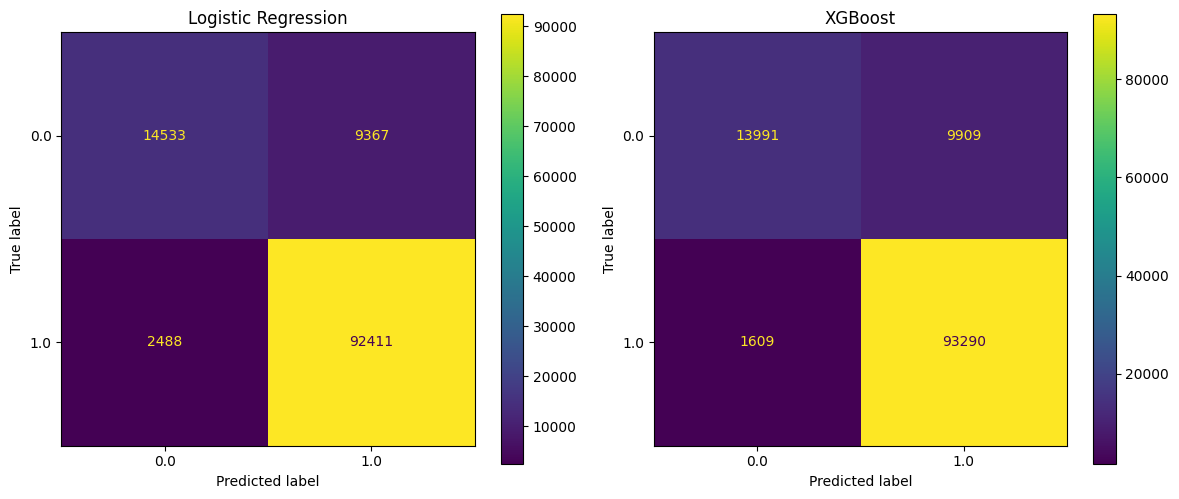


########## Logistic Regression ##########
Accuracy : 0.9002095977238865
F1 Score : 0.9397235060530718
ROC AUC : 0.9098618963362987

Classification Report:

              precision    recall  f1-score   support

         0.0       0.85      0.61      0.71     23900
         1.0       0.91      0.97      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.88      0.79      0.83    118799
weighted avg       0.90      0.90      0.89    118799


########## XGBoost ##########
Accuracy : 0.9030463219387369
F1 Score : 0.9418570606467506
ROC AUC : 0.9157888364555473

Classification Report:

              precision    recall  f1-score   support

         0.0       0.90      0.59      0.71     23900
         1.0       0.90      0.98      0.94     94899

    accuracy                           0.90    118799
   macro avg       0.90      0.78      0.83    118799
weighted avg       0.90      0.90      0.89    118799



In [59]:
# -------------------------------
# 7) Make predictions
# -------------------------------
log_pred = log_grid.predict(X_val)
log_proba = log_grid.predict_proba(X_val)[:, 1]

xgb_pred = xgb_grid.predict(X_val)
xgb_proba = xgb_grid.predict_proba(X_val)[:, 1]

# -------------------------------
# 8) Evaluation helper
# -------------------------------
def evaluate_model(name, y_true, pred, proba):
    print(f"\n########## {name} ##########")
    print("Accuracy :", accuracy_score(y_true, pred))
    print("F1 Score :", f1_score(y_true, pred))
    print("ROC AUC :", roc_auc_score(y_true, proba))
    print("\nClassification Report:\n")
    print(classification_report(y_true, pred))

# -------------------------------
# 9) Compare the two models
# -------------------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression
ConfusionMatrixDisplay.from_predictions(y_val, log_pred, ax=axes[0])
axes[0].set_title("Logistic Regression")

# XGBoost
ConfusionMatrixDisplay.from_predictions(y_val, xgb_pred, ax=axes[1])
axes[1].set_title("XGBoost")

plt.tight_layout()
plt.show()

evaluate_model("Logistic Regression", y_val, log_pred, log_proba)
evaluate_model("XGBoost", y_val, xgb_pred, xgb_proba)

### ROC Curve

<Figure size 800x600 with 0 Axes>

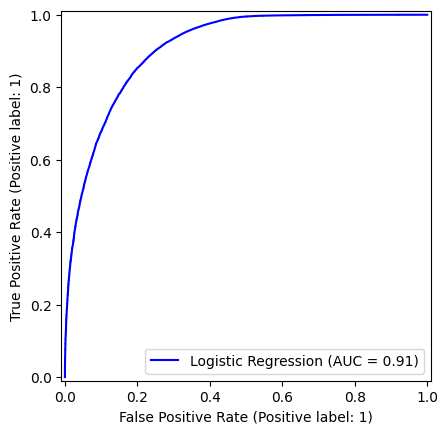

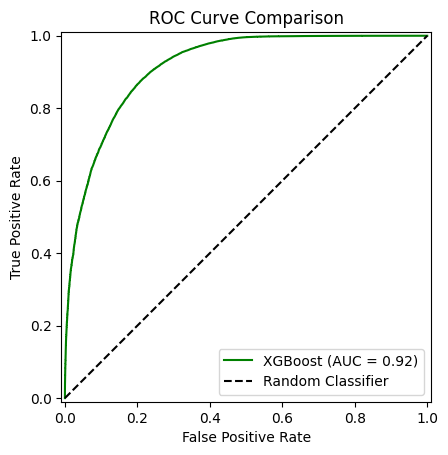

In [60]:
# ------------------------------------------------------------
# 10) ROC Curve Comparison
# ------------------------------------------------------------
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8,6))

# Logistic Regression ROC
RocCurveDisplay.from_predictions(
    y_val, log_proba,
    name="Logistic Regression",
    color="blue"
)

# XGBoost ROC
RocCurveDisplay.from_predictions(
    y_val, xgb_proba,
    name="XGBoost",
    color="green"
)

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")  # diagonal line
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Model Training
over the full training set

In [61]:
# Assume XGBoost performed best
final_model = xgb_grid
final_model.fit(X, y)  # Train on full training set

# Align columns with training set
df_test_enc = df_test_enc.reindex(columns=X.columns, fill_value=0)

# Predict probabilities
test_proba = final_model.predict_proba(df_test_enc)[:,1]

### Kaggle Submission

In [ ]:
# Submission
submission = pd.DataFrame()
submission["id"] = test["id"]
submission["loan_paid_back"] = test_proba

submission.to_csv("submission.csv", index=False)
print("submission.csv created!") # Submission